In [39]:
import sys
import os

# modify syspath directory to sys.path

package_path = os.path.abspath(os.path.join('..','core'))
if package_path not in sys.path:
    sys.path.append(package_path)

package_path = os.path.abspath(os.path.join('..','utils'))
if package_path not in sys.path:
    sys.path.append(package_path)

package_path = os.path.abspath(os.path.join('..'))
if package_path not in sys.path:
    sys.path.append(package_path)

import numpy as np
import qutip as qt
import math
import matplotlib.pyplot as plt
import pickle

from IPython.display import HTML # both needed to disply gifs
from PIL import Image

# Import modules from the package
from core import create_hamiltonian as ch
from core import create_state as cs
from core import create_coherent_state
from core import time_evo
from core import time_evo_new
from core import time_evo_from_state
from core import time_evo_rd_ACL
from core import load_param
from core import load_H_list
from core import load_result
from core import load_tlist
from core import operators
from core.schmidt_solve import compute_schmidt_states_all_time
from core.eigen_ener_states import eigen_ener_states as eig
from core import annihilation_operator
from utils.entropy import compute_VN, plot_VN, compute_VN_time, plot_VN_numpy
from utils import collapse_gif
from utils.collapse_gif import collapse_gif
from utils.display_gif import display_gif
from utils.distribution_gif import gif_distribution_eig_total
from utils.distribution_gif import prob_gif
from utils.distribution_gif import gif_distrib_H_s_int
from utils.distribution_gif import gif_distrib_system_first_eig
from utils.plot import plot_basic
from utils.plot import plot_with_binning
from utils.basic_functions import state_distribution_eig_tot
from utils.basic_functions import random_dephasing
from utils.basic_functions import get_state_probabilities
from utils.basic_functions import position
from utils.basic_functions import copy_cat
from utils.basic_functions import plot_einselection
from utils.overlap import overlap
from utils.overlap import gif_schmidt_overlap
from utils.interference import interference_plot
from utils.expectations import exp_val_time
from utils.plot_hamiltonians import plot_hamiltonians
from utils.locality_utils import create_e_state,create_H_non_local_H0, create_H_non_local_H1,create_H_2_local_H0, create_H_2_local_H1,create_H_2_local,create_H_non_local,create_state_2_local

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.titlesize'] = 16             # Title font size
plt.rcParams['axes.titleweight'] = 'bold'       # Title font weight
plt.rcParams['axes.labelsize'] = 14             # X and Y label font size
plt.rcParams['axes.labelweight'] = 'bold'       # X and Y label font weight
#plt.rcParams['axes.grid'] = True                # Enable grid
#plt.rcParams['grid.alpha'] = 0.7                # Grid transparency
#plt.rcParams['grid.linestyle'] = '--'           # Grid line style
#plt.rcParams['grid.color'] = 'gray'             # Grid color

# Tick settings
plt.rcParams['xtick.labelsize'] = 12            # X tick label size
plt.rcParams['ytick.labelsize'] = 12            # Y tick label size
plt.rcParams['xtick.direction'] = 'in'          # X tick direction
plt.rcParams['ytick.direction'] = 'in'          # Y tick direction
plt.rcParams['xtick.major.size'] = 6            # X major tick size
plt.rcParams['ytick.major.size'] = 6            # Y major tick size

# Legend settings
plt.rcParams['legend.fontsize'] = 12            # Legend font size
plt.rcParams['legend.frameon'] = True           # Enable legend frame
plt.rcParams['legend.framealpha'] = 0.9         # Legend frame transparency
plt.rcParams['legend.loc'] = 'best'             # Legend location

# Line and marker settings
plt.rcParams['lines.linewidth'] = 2             # Line width
plt.rcParams['lines.markersize'] = 6            # Marker size

custom_colors = ['#1c4587', '#e6194B', '#2ca02c', '#d62728', '#9467bd', 
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

temp code to put in local_utils

In [40]:
#We define a function to see the overlap between environemnt states.
def plot_overlap(n_e, file_name,file_suffixes,log_t):
    """
    Calculate and plot |r(t)|^2, the overlap between two environment states.

    Parameters:
    t_list (array-like): List of time points.
    state1 (qutip.Qobj): First environment state.
    state2 (qutip.Qobj): Second environment state.
    """

    d_2=2**n_e
    identity = qt.qeye(d_2)  # Adjust dimension if needed
    #density_matrix = qt.ptrace(global_state, [0]) # Calculate the density matrix at the specified time
    # Construct the full projection operator |0><0| ⊗ I
    ket_0 = qt.basis(2, 0)  # |0>
    ket_1 = qt.basis(2, 1)  # |0>
    proj_0 = ket_0 * ket_0.dag()  # |0><0|
    proj_1 = ket_0 * ket_1.dag()  # |0><0|
    proj_op_0 = qt.tensor(proj_0, identity)
    proj_op_1 = qt.tensor(proj_1, identity)
    result_list=[]
    for suffix in file_suffixes:
        file_name_2=f"{file_name}_{suffix}"
        tmax, ind_nb, log = load_param(file_name_2)
        tlist = load_tlist(file_name_2)
        result = load_result(file_name_2)
        result_list.append(result)
    
    l=len(file_suffixes)
    o_list=[]
    for j in range(l):
        overlap_values=[]
        for i in range(ind_nb):
            global_state = result_list[j].states[i]
            e0=proj_op_0 * global_state
            e1=proj_op_1 * global_state
            overlap_values.append(abs(e0.overlap(e1)*np.conjugate(e1.overlap(e0))))
        o_list.append(overlap_values)

    # Plot the results
    from matplotlib import cm
    blues = cm.Blues(np.linspace(0.4, 0.8, l+1))  # Blue shades for the first 4 (local)

    # Plot for local Hamiltonian
    for i in range(l):
        plt.plot(tlist, o_list[i], color=blues[i])
    
    if log_t==True:
        plt.xscale('log')

    
    plt.xlabel('Time')
    plt.ylabel(r'$|r(t)|^2$')#plt.title('Von Neumann Entropy over time')
    
    plt.grid(True)
    plt.legend()
    name=file_name+"r"+".pickle"
    with open(name, 'wb') as f:
        pickle.dump(plt.gcf(), f)  # Save the current figure (gcf)
    plt.show()
    


def plot_overlap_2(n_e,file_name_local,file_name_non_local,file_suffixes,log_t):
    d_2=2**n_e
    identity = qt.qeye(d_2)  # Adjust dimension if needed
    #density_matrix = qt.ptrace(global_state, [0]) # Calculate the density matrix at the specified time
    # Construct the full projection operator |0><0| ⊗ I
    ket_0 = qt.basis(2, 0)  # |0>
    ket_1 = qt.basis(2, 1)  # |0>
    proj_0 = ket_0 * ket_0.dag()  # |0><0|
    proj_1 = ket_0 * ket_1.dag()  # |0><0|
    proj_op_0 = qt.tensor(proj_0, identity)
    proj_op_1 = qt.tensor(proj_1, identity)
    l=len(file_suffixes)

    result_list_local=[]
    for suffix in file_suffixes:
        file_name_2=f"{file_name_local}_{suffix}"
        tmax, ind_nb, log = load_param(file_name_2)
        tlist = load_tlist(file_name_2)
        result = load_result(file_name_2)
        result_list_local.append(result)

    
    o_list_local=[]
    for j in range(l):
        overlap_values=[]
        for i in range(ind_nb):
            global_state = result_list_local[j].states[i]
            e0=proj_op_0 * global_state
            e1=proj_op_1 * global_state
            overlap_values.append(abs(e0.overlap(e1)*np.conjugate(e1.overlap(e0))))
        o_list_local.append(overlap_values)

        result_list_nlocal=[]
    for suffix in file_suffixes:
        file_name_2=f"{file_name_non_local}_{suffix}"
        tmax, ind_nb, log = load_param(file_name_2)
        tlist = load_tlist(file_name_2)
        result = load_result(file_name_2)
        result_list_nlocal.append(result)
    
    
    o_list_nlocal=[]
    for j in range(l):
        overlap_values=[]
        for i in range(ind_nb):
            global_state = result_list_nlocal[j].states[i]
            e0=proj_op_0 * global_state
            e1=proj_op_1 * global_state
            overlap_values.append(abs(e0.overlap(e1)*np.conjugate(e1.overlap(e0))))
        o_list_nlocal.append(overlap_values)

    # Plot the results
    from matplotlib import cm
    blues = cm.Blues(np.linspace(0.4, 0.8, l+1))  # Blue shades for the first 4 (local)
    reds = cm.Reds(np.linspace(0.4, 0.8, l+1))    # Red shades for the second 4 (non-local)

    # Plot for local Hamiltonian
    for i in range(l-1):
        plt.plot(tlist, o_list_local[i], color=blues[i])
    for i in range(l-1):
        plt.plot(tlist, o_list_nlocal[i], color=reds[i])
    plt.plot(tlist, o_list_local[l-1], color=blues[l-1],label="Local")
    plt.plot(tlist, o_list_nlocal[l-1], color=reds[l-1],label="Non-local")
    if log_t==True:
        plt.xscale('log')

    
    plt.xlabel('Time')
    plt.ylabel(r'$|r(t)|^2$')#plt.title('Von Neumann Entropy over time')
    
    plt.grid(True)
    plt.legend()
    name=file_name_local+"r"+".pickle"
    with open(name, 'wb') as f:
        pickle.dump(plt.gcf(), f)  # Save the current figure (gcf)
    plt.show()



Getting the general decoherence thing

wtf
wtf


/var/folders/_c/g_dqs4_d21s6r5cp96lffgvw0000gp/T/ipykernel_5058/4290723241.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


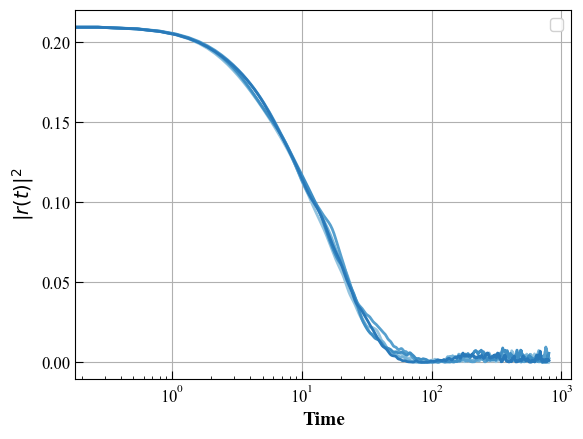

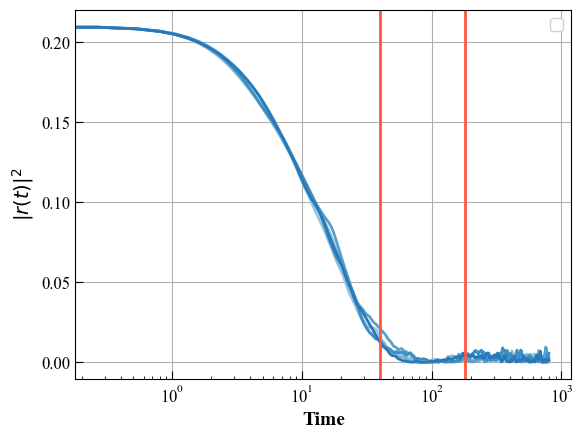

In [134]:
n_e=8
file_name="general_decoherence"
file_suffixes=[1,2,3,4,5]
log=1

plot_overlap(n_e,file_name,file_suffixes,True)

name="general_decoherence"+"r"+".pickle"
# Reopen the saved plot
with open(name, 'rb') as f:
    fig = pickle.load(f)

# Edit the plot (e.g., add vertical lines)
plt.figure(fig.number)  # Set the figure to the loaded one
plt.axvline(x=40, color='#ff5544', linestyle='-') 
plt.axvline(x=180, color='#ff5544', linestyle='-') 
plt.xscale('log')
# Show the modified plot
plt.show()

# Save the modified plot as a PNG image
modified_name = "general_decoherence" + "r" + "_modified" + ".pdf"

fig.savefig(modified_name)  # Save the figure as a PNG file


Now we use this function to see if the difference also appears for local v non-local

"2_locality_2" makes it clear that the non-local Hamiltonian is faster

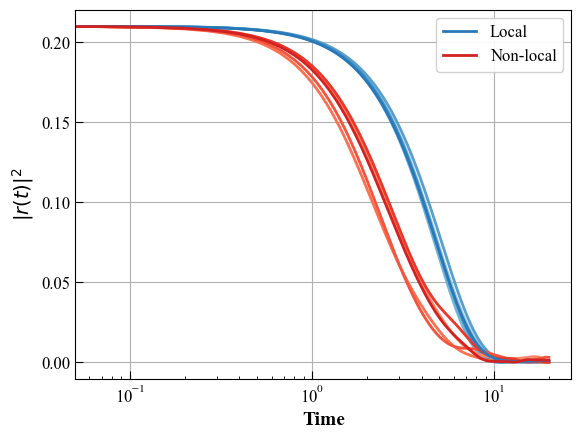

In [ ]:
n_e=8
log=0
tmax=20
ind_nb=200
a1=0.5
a2=0.75
a3=0.2

plot_overlap_2(n_e,"2_locality_2","non_locality_2",[1,2,3,4,5],True)

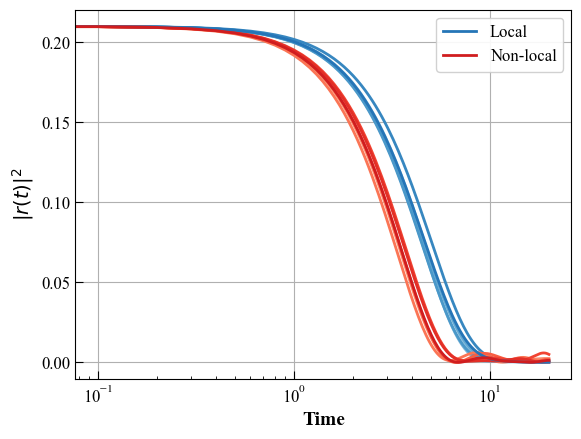

In [43]:
n_e=8
log=0
tmax=20
ind_nb=200
a1=0.5
a2=0
a3=0.2

plot_overlap_2(n_e,"ae_0_local","ae_0_non_local",[1,2,3,4,5,6],True)

"2-local_decoherence" has that thing where the local case becomes much faster.

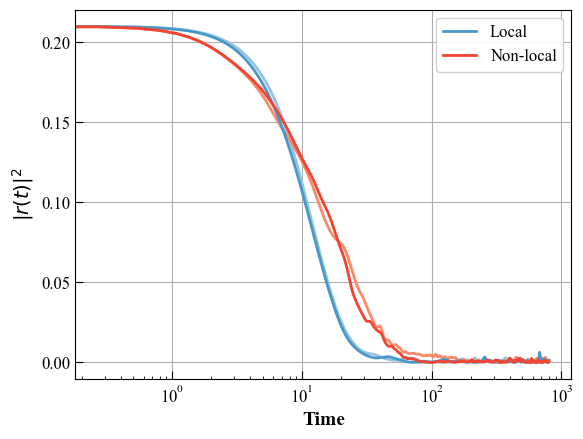

In [ ]:
n_e=8
log=0
tmax=800
ind_nb=3000
a1=0.002
a2=0.75
a3=0.1

plot_overlap_2(n_e,"2_local_decoherence","non_locality_decoherence",[1,2],True)

We start by looking at the overall spectrum.

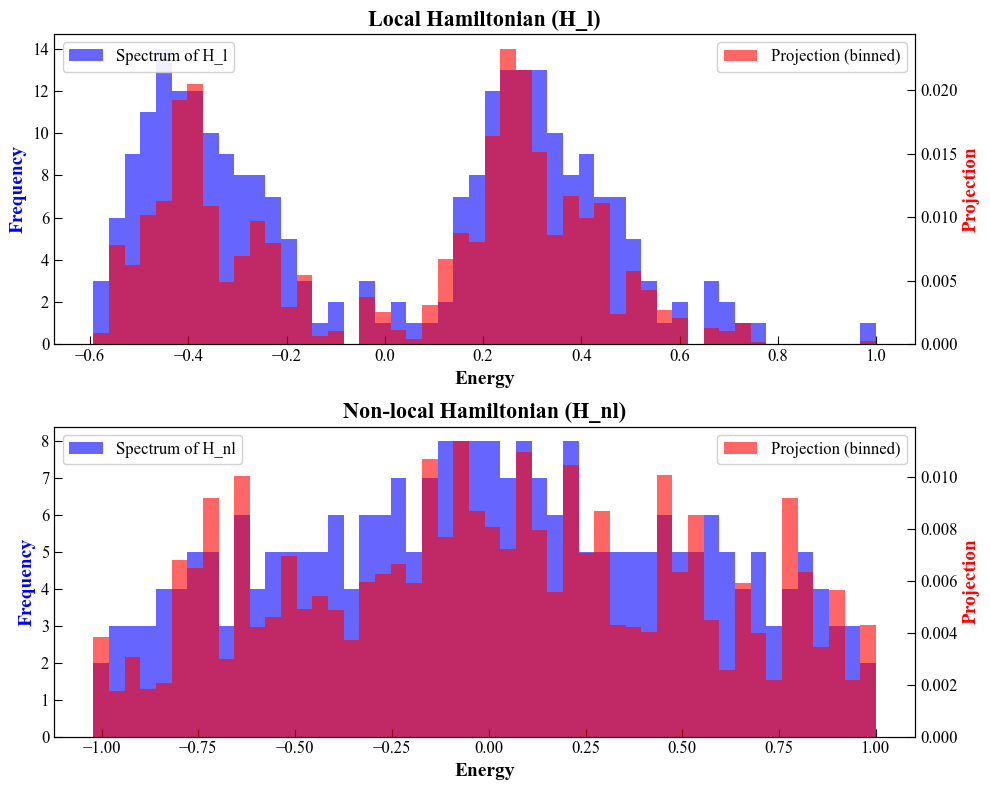

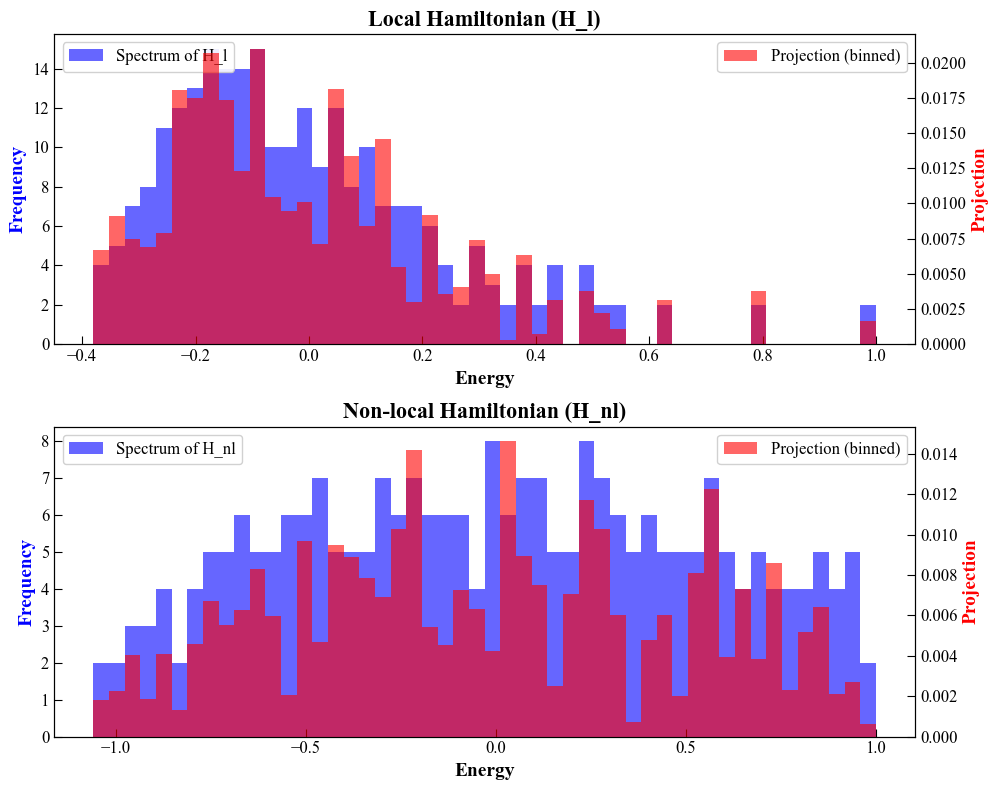

In [44]:
import numpy as np
import matplotlib.pyplot as plt
#create_H_2_local create_H_non_local
def plot_spectrum_and_state_bined2(n=8, a1=0.5, a2=0.75, a3=0.1):
    H_l = create_H_2_local(n, a1, a2, a3)
    eigenenergies_l, eigenstates_l = H_l.eigenstates()

    H_nl = create_H_non_local(n, a1, a2, a3)
    eigenenergies_nl, eigenstates_nl = H_nl.eigenstates()

    psi = create_state_2_local(n)

    # Project the state into the eigenbasis of H_l and H_nl
    psi_l_list = []
    psi_nl_list = []

    for i in range(2**n):
        # Overlap of psi with eigenstates of H_l and H_nl
        psi_l_list.append(abs(psi.overlap(eigenstates_l[i]))**2)
        psi_nl_list.append(abs(psi.overlap(eigenstates_nl[i]))**2)

    # Create a figure with two subplots for H_l and H_nl
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Local Hamiltonian (H_l): Plot binned energy spectrum and projection histogram on two y-axes
    ax1.hist(eigenenergies_l, bins=50, alpha=0.6, color='b', label='Spectrum of H_l')  # Binned energy spectrum
    ax1.set_xlabel("Energy")
    ax1.set_ylabel("Frequency", color='b')

    ax1_twin = ax1.twinx()
    ax1_twin.hist(eigenenergies_l, bins=50, weights=psi_l_list, alpha=0.6, color='r', label='Projection (binned)')  # Projection histogram
    ax1_twin.set_ylabel("Projection", color='r')

    ax1.set_title("Local Hamiltonian (H_l)")
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')

    # Non-local Hamiltonian (H_nl): Plot binned energy spectrum and projection histogram on two y-axes
    ax2.hist(eigenenergies_nl, bins=50, alpha=0.6, color='b', label='Spectrum of H_nl')  # Binned energy spectrum
    ax2.set_xlabel("Energy")
    ax2.set_ylabel("Frequency", color='b')

    ax2_twin = ax2.twinx()
    ax2_twin.hist(eigenenergies_nl, bins=50, weights=psi_nl_list, alpha=0.6, color='r', label='Projection (binned)')  # Projection histogram
    ax2_twin.set_ylabel("Projection", color='r')

    ax2.set_title("Non-local Hamiltonian (H_nl)")
    ax2.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')

    # Show the combined plot
    plt.tight_layout()
    plt.show()

a1=0.5
a2=0.75 #0
a3=0.2
plot_spectrum_and_state_bined2(8,a1,a2,a3)
a1=0.002
a2=0.75
a3=0.1
plot_spectrum_and_state_bined2(8,a1,a2,a3)

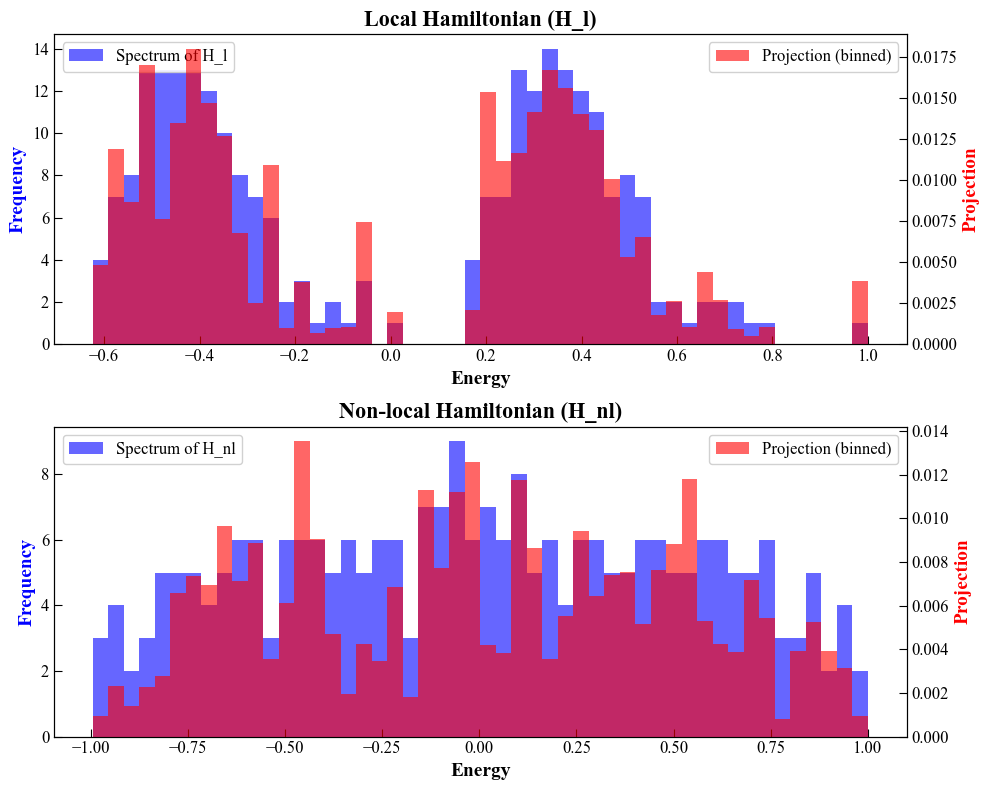

In [58]:
a1=0.7
a2=0.9
a3=0.2
plot_spectrum_and_state_bined2(8,a1,a2,a3)


Now that we have 2 representative examples, we want to see if the spectrum of H3 and the projection of the state in its eigenstates together can make this make sense.

/var/folders/_c/g_dqs4_d21s6r5cp96lffgvw0000gp/T/ipykernel_10593/1666228500.py:50: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  cost = abs(round(np.sum(cost_list), 2))
/var/folders/_c/g_dqs4_d21s6r5cp96lffgvw0000gp/T/ipykernel_10593/1666228500.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binned_projection[bin_index] += projection[j]


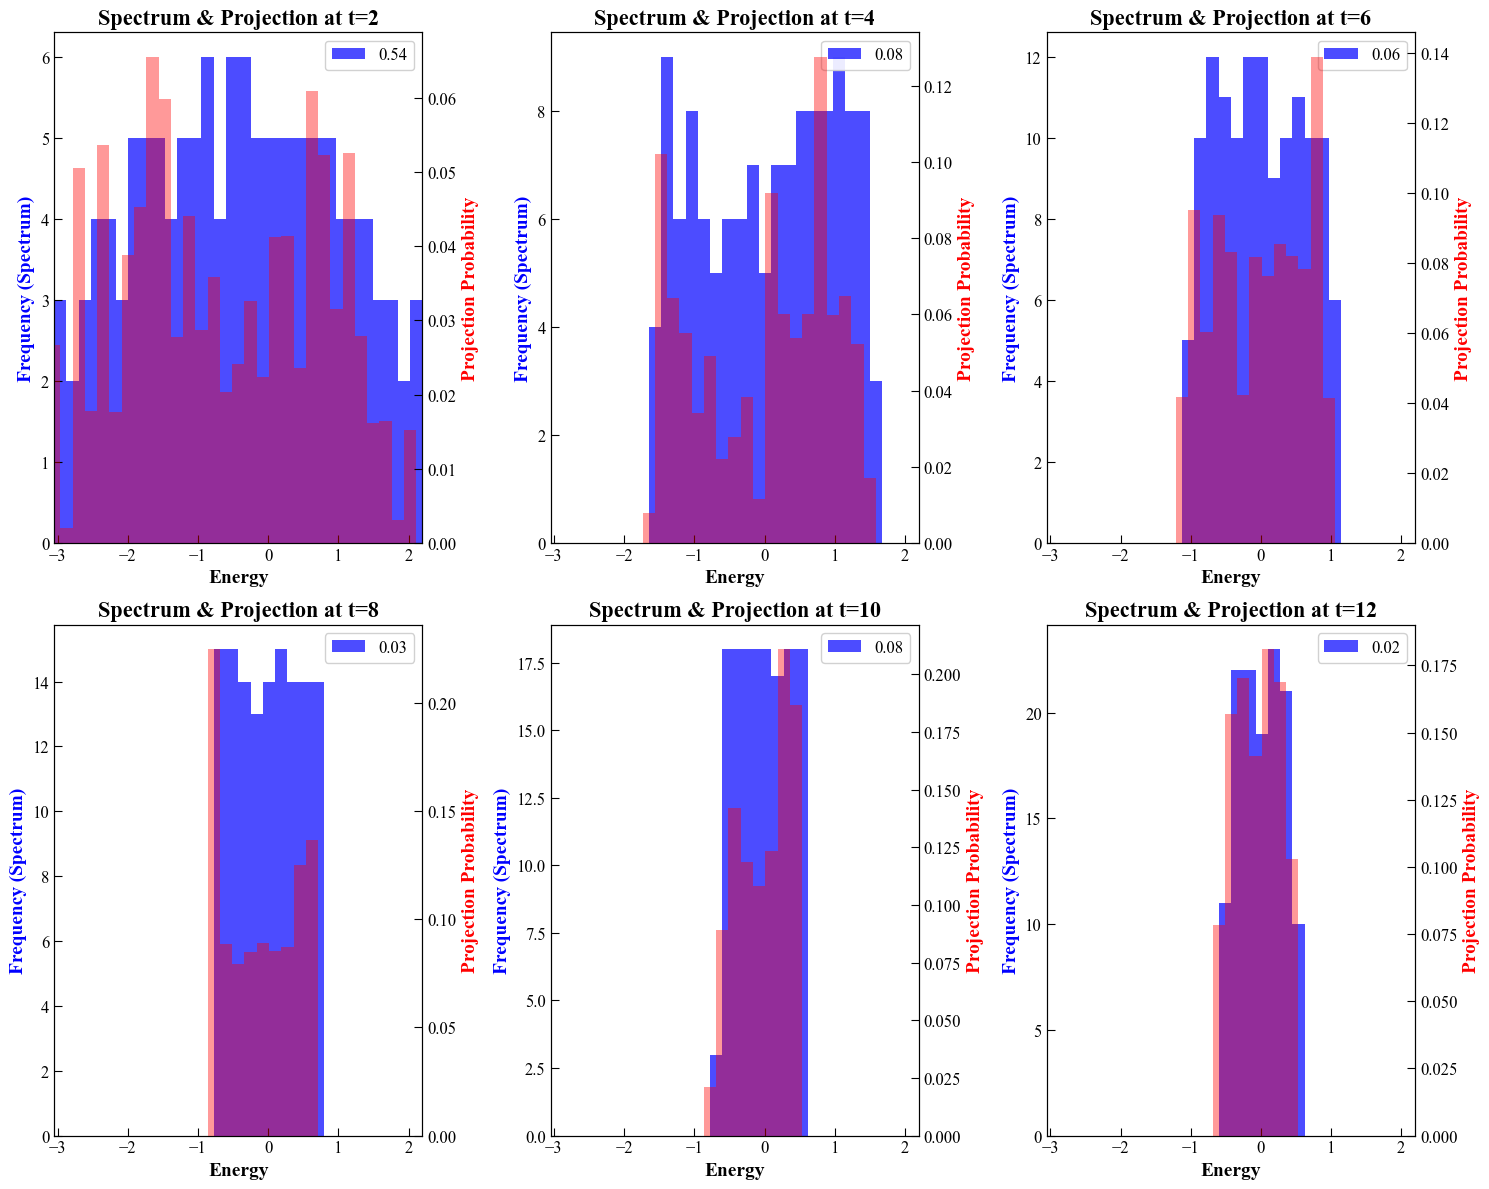

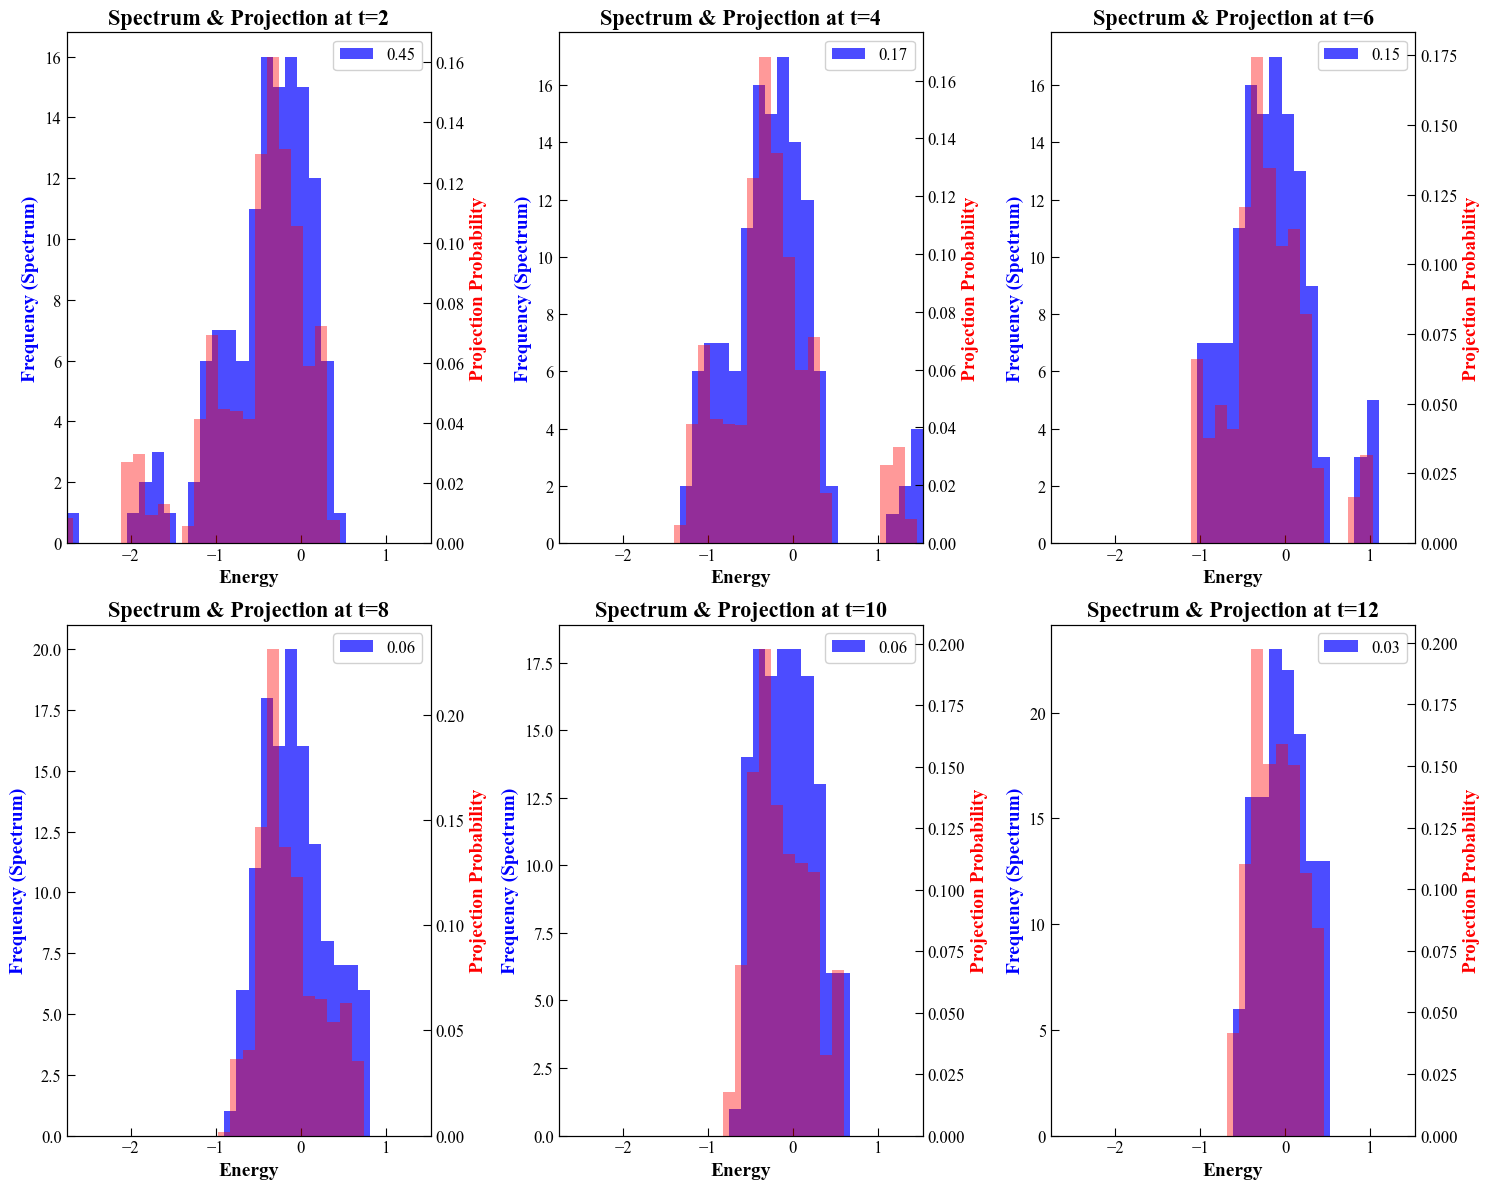

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import logm

def H3_evolution(create_H_function_H1, create_H_function_H2, psi, n=8, r=4, a1=0.5, a2=0.75, a3=0.2, f=2):
    # Assuming you have already defined the function `create_H_non_local_H0` and `create_H_non_local_H1`
    H1 = create_H_function_H1(n, a1, a2, a3)
    H2 = create_H_function_H2(n, a1, a2, a3)

    # Compute the global range of eigenvalues for consistent x-axis limits
    global_min = float('inf')
    global_max = float('-inf')

    for i in range(r):
        t = i + 1
        U1 = (-1j * H1 * t * f).expm()  # Unitary evolution from H1
        U2 = (-1j * H2 * t * f).expm()  # Unitary evolution from H2
        U_temp = (U1 * U2).full()  # Matrix product of U1 and U2

        # Compute H3 using the logarithm of the product of U1 and U2
        H3 = (1j / t) * logm(U_temp)
        eigenvalues = np.linalg.eigvals(H3)

        # Update global range
        global_min = min(global_min, np.min(eigenvalues.real))
        global_max = max(global_max, np.max(eigenvalues.real))

    # Define bins based on the global eigenvalue range
    num_bins = 30
    bins = np.linspace(global_min, global_max, num_bins + 1)

    # Define the figure layout
    rows = 2  # Number of rows
    cols = r // rows  # Number of columns
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
    axes = axes.flatten()

    for i in range(r):
        t = i + 1
        U1 = (-1j * H1 * t * f).expm()
        U2 = (-1j * H2 * t * f).expm()
        U_temp = (U1 * U2).full()

        H3 = (1j / t) * logm(U_temp)
        eigenvalues, eigenvectors = np.linalg.eig(H3)

        # Compute the projection of the state psi onto the eigenbasis
        projection = np.abs(eigenvectors.T.conj() @ psi) ** 2
        cost_list = [eig * ci for eig, ci in zip(eigenvalues, projection)]
        cost = abs(round(np.sum(cost_list), 2))

        # Compute the binned histogram for the spectrum of eigenvalues
        spectrum_hist, _ = np.histogram(eigenvalues.real, bins=bins)

        # Compute the binned projection
        binned_projection = np.zeros_like(spectrum_hist, dtype=float)
        for j in range(len(eigenvalues)):
            bin_index = np.digitize(eigenvalues.real[j], bins) - 1
            if 0 <= bin_index < len(binned_projection):
                binned_projection[bin_index] += projection[j]

        # Plot on the respective axes
        ax = axes[i]
        ax.hist(eigenvalues.real, bins=bins, alpha=0.7, color='b', label=f"{cost}")
        ax2 = ax.twinx()
        ax2.bar(bins[:-1], binned_projection, width=np.diff(bins), alpha=0.4, color='r', label="Projection")

        # Set labels, title, and limits
        ax.set_xlim(global_min, global_max)
        ax.set_title(f"Spectrum & Projection at t={t * f}")
        ax.set_xlabel("Energy")
        ax.set_ylabel("Frequency (Spectrum)", color='b')
        ax2.set_ylabel("Projection Probability", color='r')
        ax.legend(loc='upper right')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Example usage
n = 8
psi = create_e_state(n - 1).full()
a1 = 0.5
a2 = 0.75
a3 = 0.2
#I SHOULD USE THE OTHER FUNCTIONS TO CREAT H LOCAL!!!   
H3_evolution(create_H_non_local_H0, create_H_non_local_H1, psi, n, 6, a1, a2, a3, 2)
H3_evolution(create_H_2_local_H0, create_H_2_local_H1, psi, n, 6, a1, a2, a3, 2)


/var/folders/_c/g_dqs4_d21s6r5cp96lffgvw0000gp/T/ipykernel_10593/3204342925.py:50: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  cost = abs(round(np.sum(cost_list), 2))
/var/folders/_c/g_dqs4_d21s6r5cp96lffgvw0000gp/T/ipykernel_10593/3204342925.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binned_projection[bin_index] += projection[j]


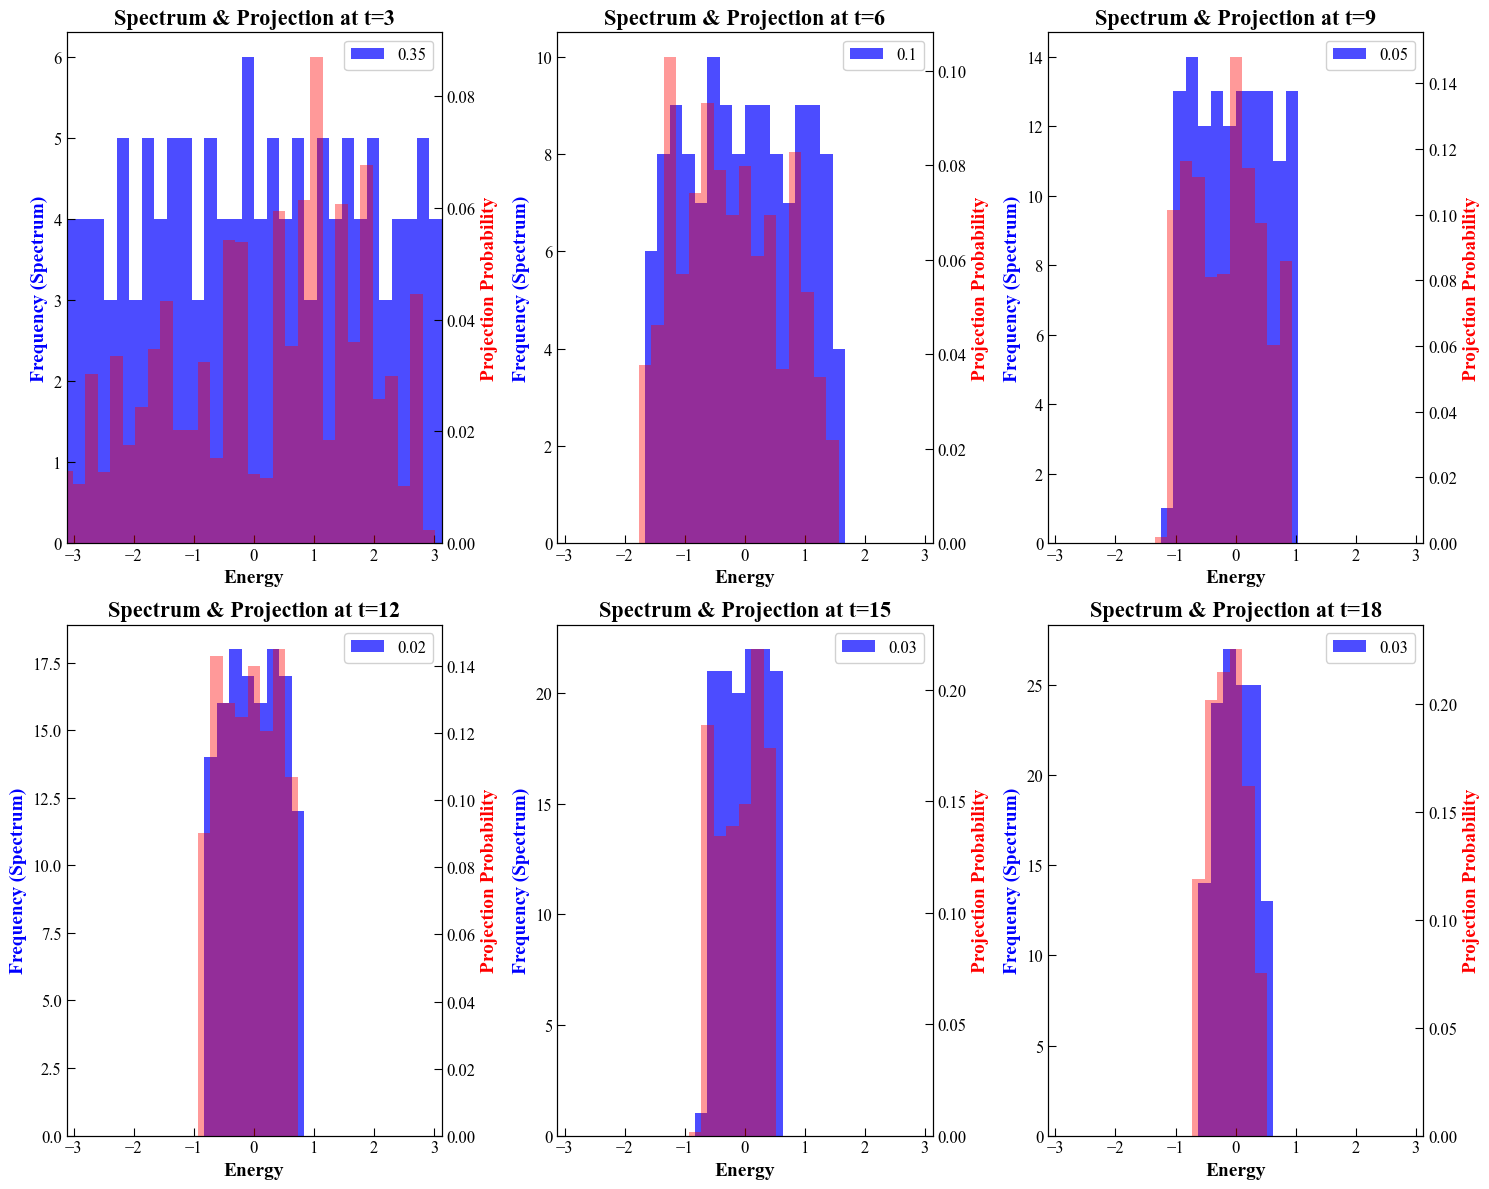

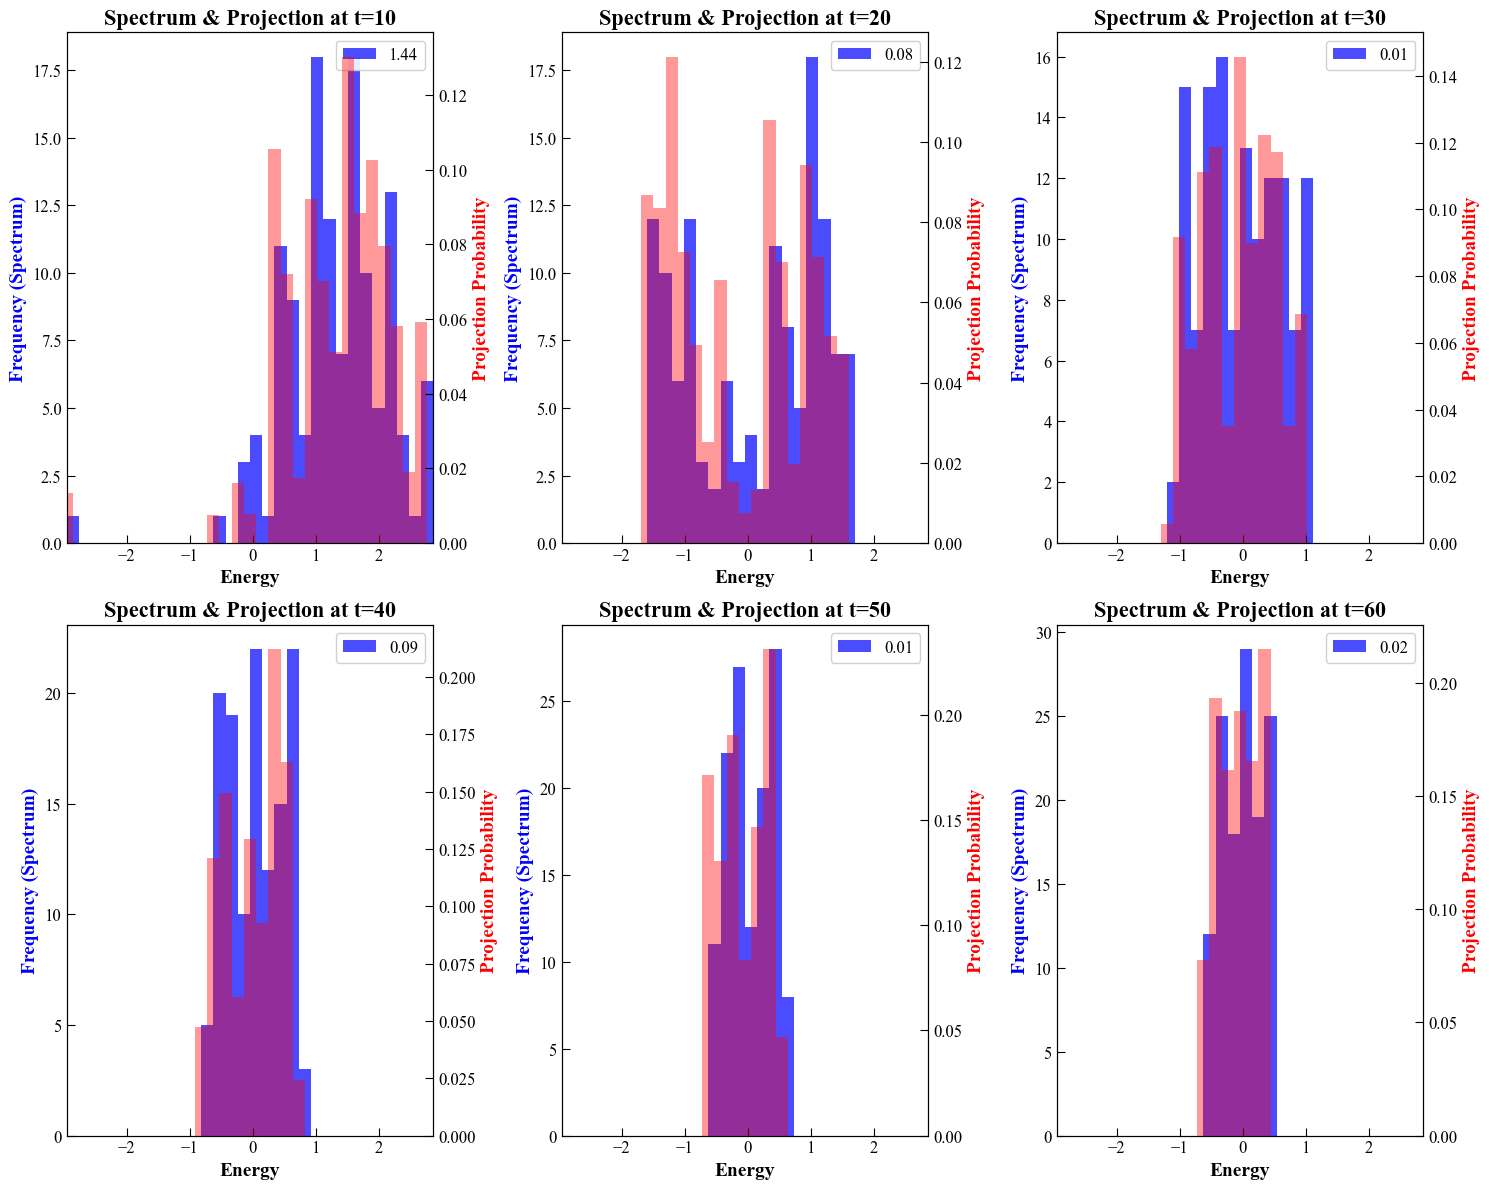

In [23]:
a1=0.002
a2=0.75
a3=0.1

H3_evolution(create_H_non_local_H0, create_H_non_local_H1, psi, n, 6, a1, a2, a3, 3)
H3_evolution(create_H_2_local_H0, create_H_2_local_H1, psi, n, 6, a1, a2, a3, 10)


We now look at distributions of E_i-E_j

The first one is a setting where the non-local is faster and we see things that make sense.

The second one is settings where the local is faster and we also see things that make sense

/var/folders/_c/g_dqs4_d21s6r5cp96lffgvw0000gp/T/ipykernel_10593/277617875.py:91: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binned_projection[bin_index] += proj_product[j]


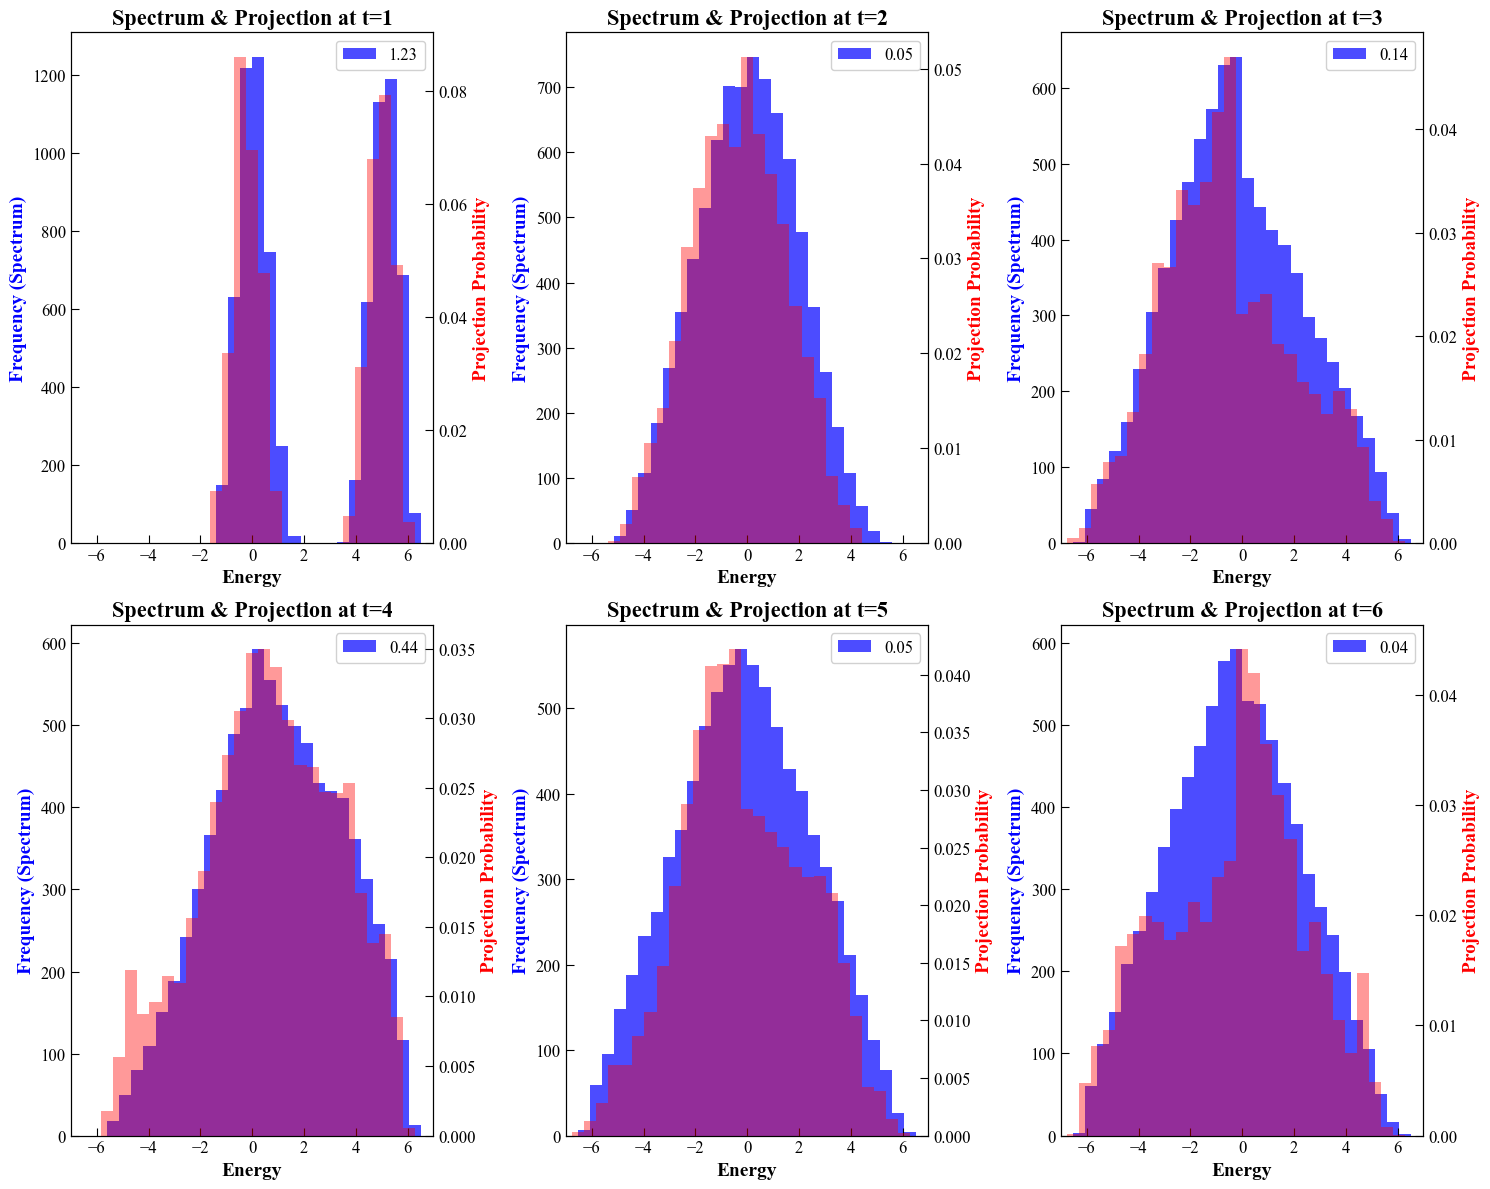

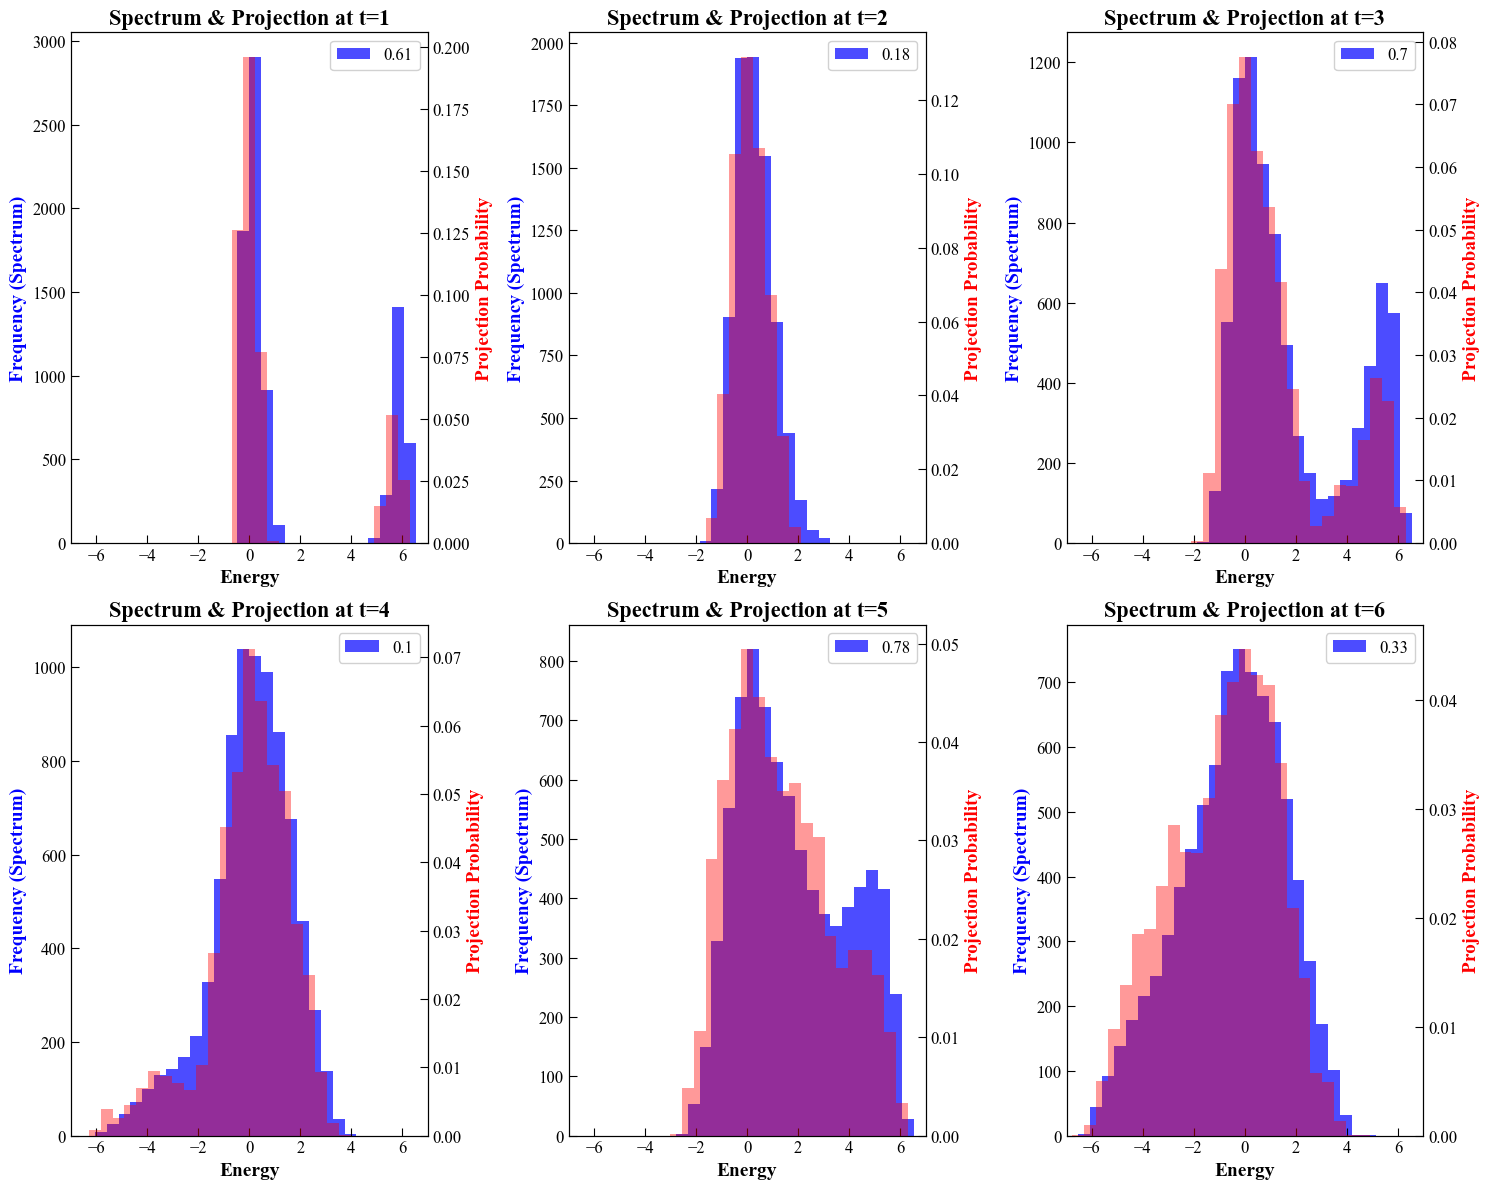

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import logm

def pairwise_differences(E):
    n = len(E)
    differences = []
    for i in range(n):
        for j in range(i):
            differences.append(E[i] - E[j])
    return np.array(differences)

def product_pair(c):
    n = len(c)
    differences = []
    for i in range(n):
        for j in range(i):
            differences.append(c[i]*c[j])
    return np.array(differences)


def H3_evolution(create_H_function_H1, create_H_function_H2, psi, n=8, r=4, a1=0.5, a2=0.75, a3=0.2, f=2,m=0):
    # Assuming you have already defined the function `create_H_non_local_H0` and `create_H_non_local_H1`
    H1 = create_H_function_H1(n, a1, a2, a3)
    H2 = create_H_function_H2(n, a1, a2, a3)

    # Compute the global range of eigenvalues for consistent x-axis limits
    global_min = float('inf')
    global_max = float('-inf')
    maximum_m = 0
    maximum_p = 0
    for i in range(r):
        t = i + 1
        U1 = (-1j * H1 * t * f).expm()  # Unitary evolution from H1
        U2 = (-1j * H2 * t * f).expm()  # Unitary evolution from H2
        U_temp = (U1 * U2).full()  # Matrix product of U1 and U2

        # Compute H3 using the logarithm of the product of U1 and U2
        H3 = (1j / t) * logm(U_temp)
        eigenvalues = np.linalg.eigvals(H3)

        # Update global range
        global_min = min(global_min, np.min(eigenvalues.real))
        global_max = max(global_max, np.max(eigenvalues.real))
        eig_diff= pairwise_differences(eigenvalues.real)
        maximum_m = min(maximum_m, np.min(eig_diff))
        maximum_p = max(maximum_p, np.max(eig_diff))
    if m==0:
        min_max=max(abs(maximum_m),abs(maximum_p))
    else:
        min_max=m
    
    # Define bins based on the global eigenvalue range
    num_bins = 30
    bins = np.linspace(-min_max, min_max, num_bins + 1)

    # Define the figure layout
    rows = 2  # Number of rows
    cols = r // rows  # Number of columns
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
    axes = axes.flatten()

    for i in range(r):
        t = i + 1
        U1 = (-1j * H1 * t * f).expm()
        U2 = (-1j * H2 * t * f).expm()
        U_temp = (U1 * U2).full()
        psi_new=U_temp @ psi
        H3 = (1j) * logm(U_temp)
        eigenvalues, eigenvectors = np.linalg.eig(H3)

        # Compute the projection of the state psi onto the eigenbasis
        projection = np.abs(eigenvectors.T.conj() @ psi_new) ** 2

        eig_diff= pairwise_differences(eigenvalues.real)

        proj_product=product_pair(projection)

        cost_list = [eig * ci for eig, ci in zip(eig_diff, proj_product)]
        cost = abs(round(np.sum(cost_list), 2))

        # Compute the binned histogram for the spectrum of eigenvalues
        spectrum_hist, _ = np.histogram(eig_diff, bins=bins)

        # Initialize binned_projection with the correct size (matching the bins)
        binned_projection = np.zeros(len(bins) - 1, dtype=float)

        for j in range(len(eig_diff)):
            bin_index = np.digitize(eig_diff[j], bins) - 1
            if 0 <= bin_index < len(binned_projection):
                binned_projection[bin_index] += proj_product[j]

        # Plot on the respective axes
        ax = axes[i]
        ax.hist(eig_diff.real, bins=bins, alpha=0.7, color='b', label=f"{cost}")
        ax2 = ax.twinx()
        ax2.bar(bins[:-1], binned_projection, width=np.diff(bins), alpha=0.4, color='r', label="Projection")

        # Set labels, title, and limits
        ax.set_xlim(-min_max, min_max)
        ax.set_title(f"Spectrum & Projection at t={t * f}")
        ax.set_xlabel("Energy")
        ax.set_ylabel("Frequency (Spectrum)", color='b')
        ax2.set_ylabel("Projection Probability", color='r')
        ax.legend(loc='upper right')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Example usage
n = 8
psi = create_e_state(n - 1).full()
a1 = 0.5
a2 = 0.75
a3 = 0.2
#I SHOULD USE THE OTHER FUNCTIONS TO CREAT H LOCAL!!!   
H3_evolution(create_H_non_local_H0, create_H_non_local_H1, psi, n, 6, a1, a2, a3, 1,7)
H3_evolution(create_H_2_local_H0, create_H_2_local_H1, psi, n, 6, a1, a2, a3, 1,7)

#Here nonlocal shoudl be faster between 0.5 to 10 units of time.

/var/folders/_c/g_dqs4_d21s6r5cp96lffgvw0000gp/T/ipykernel_10593/277617875.py:91: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  binned_projection[bin_index] += proj_product[j]


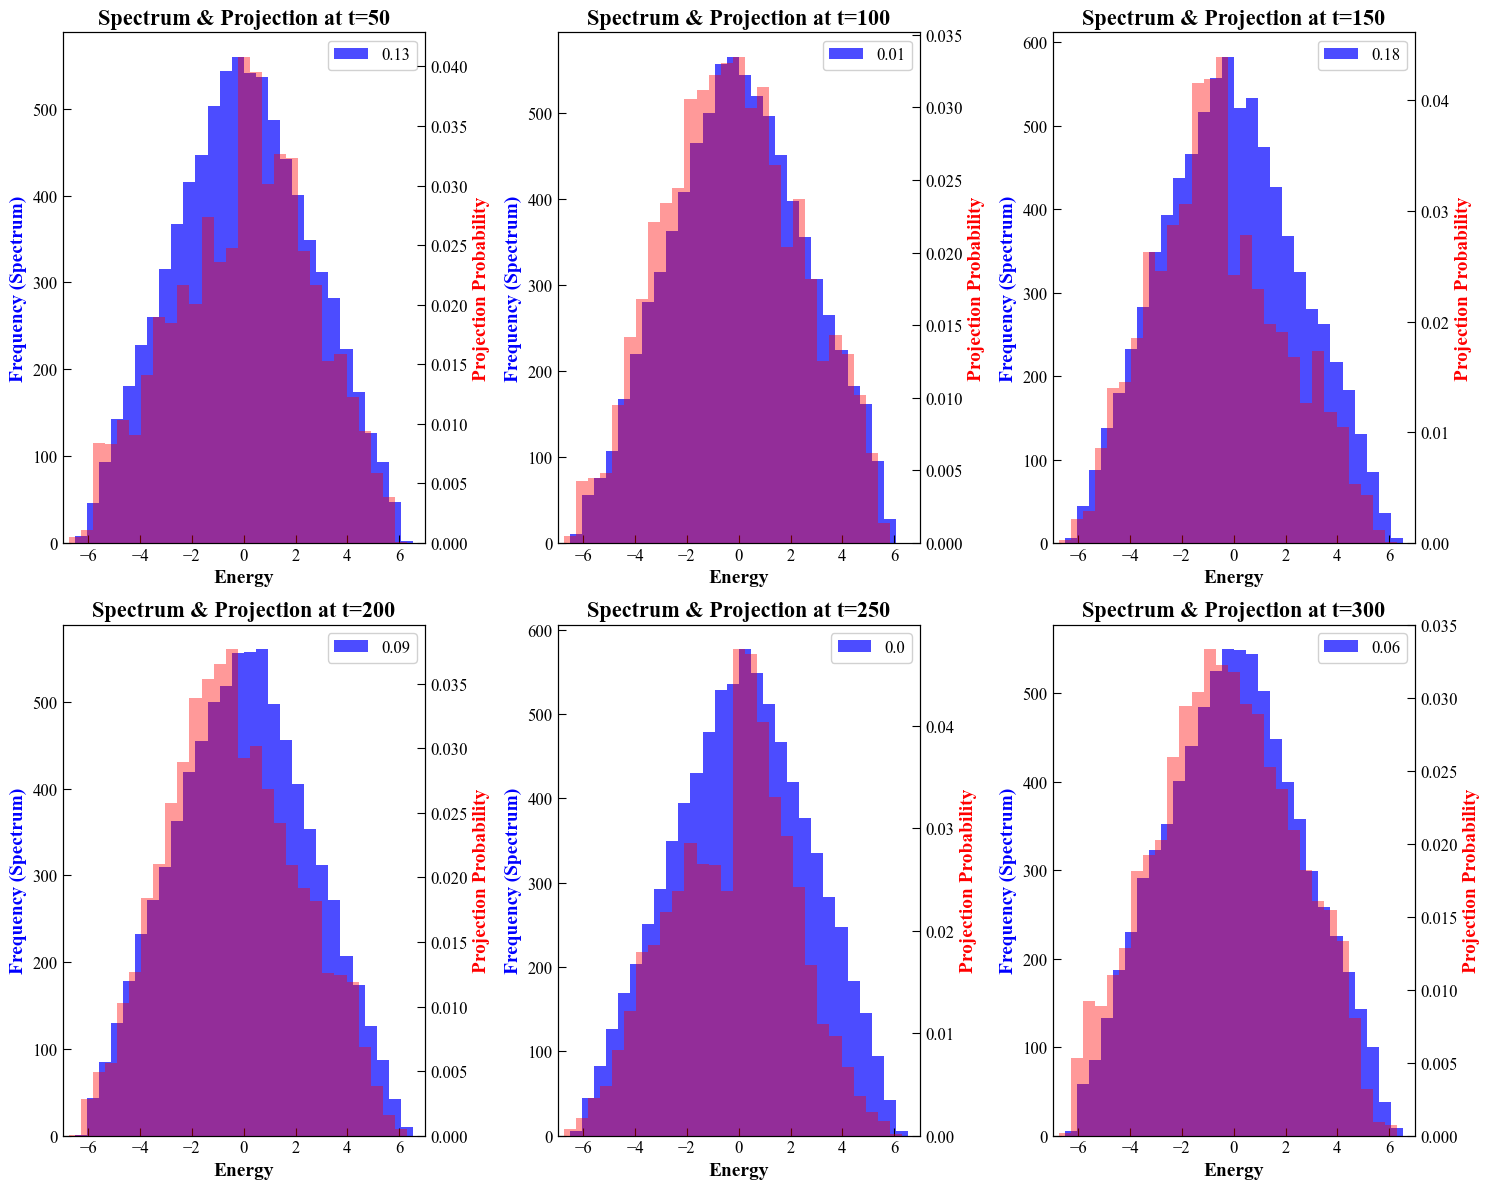

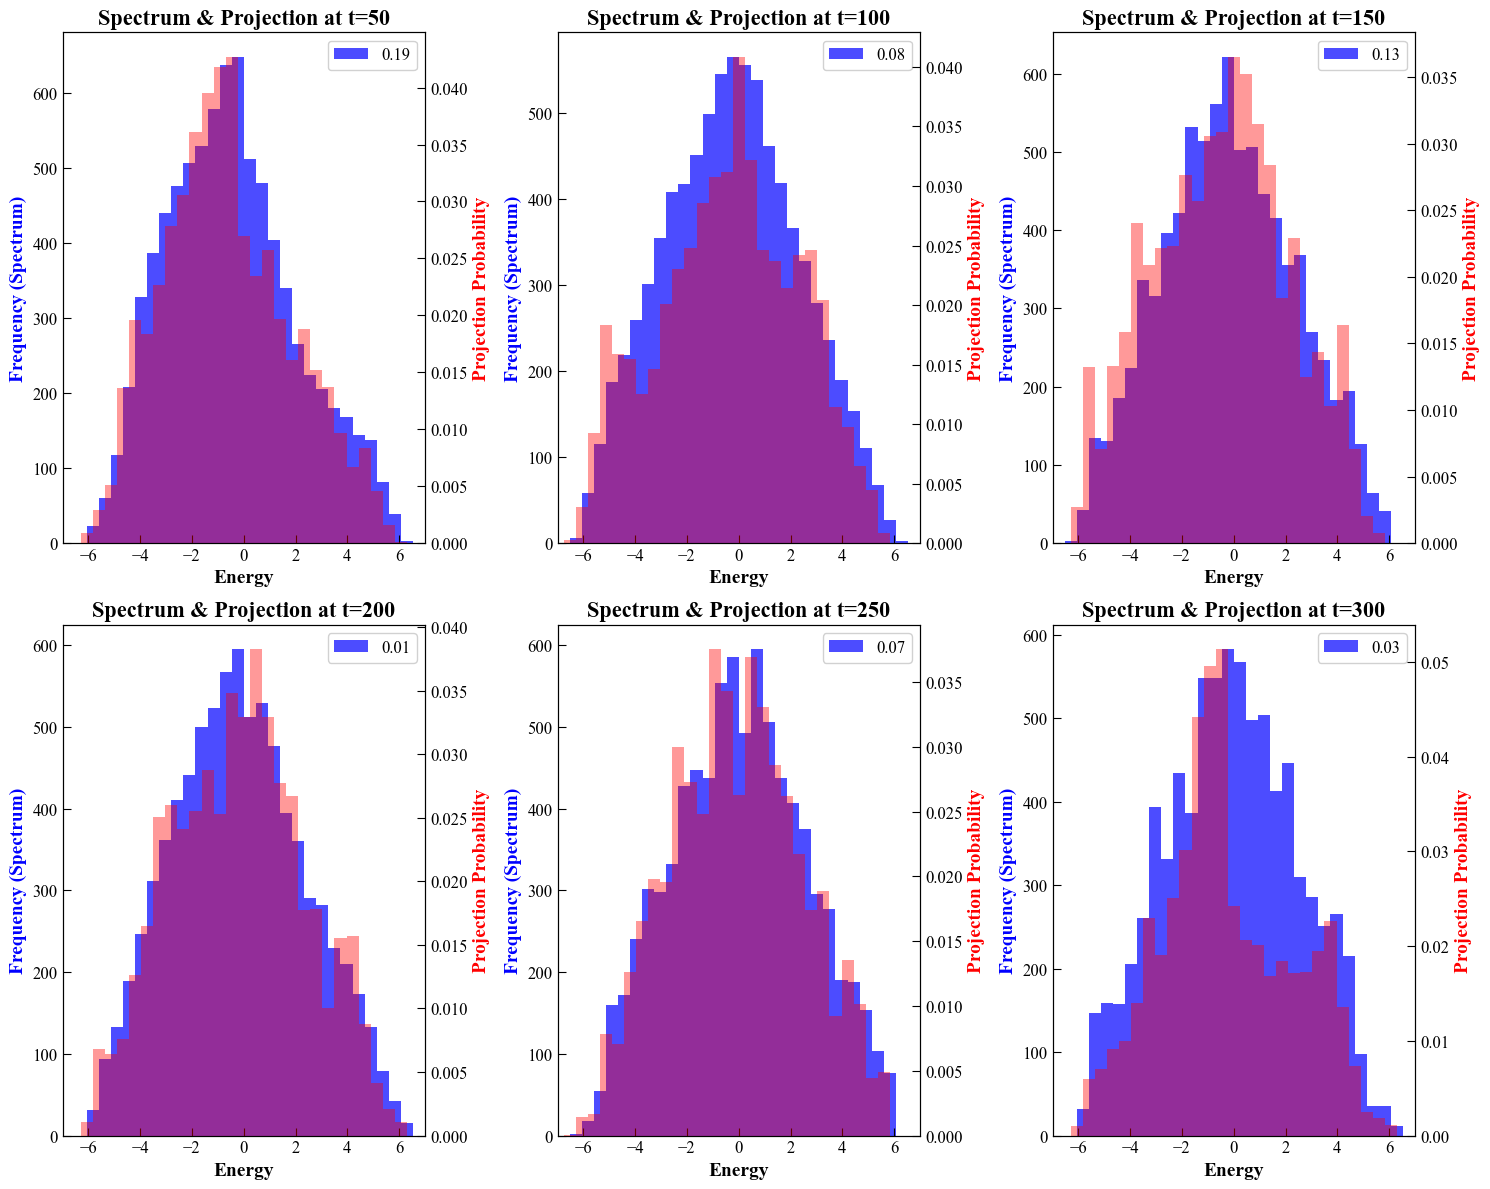

In [106]:
# Example usage
n = 8
psi = create_e_state(n - 1).full()
a1=0.002
a2=0.75
a3=0.1
#I SHOULD USE THE OTHER FUNCTIONS TO CREAT H LOCAL!!!   
H3_evolution(create_H_non_local_H0, create_H_non_local_H1, psi, n, 6, a1, a2, a3, 50,7)
H3_evolution(create_H_2_local_H0, create_H_2_local_H1, psi, n, 6, a1, a2, a3, 50,7)

#I expect to see faster decoherence for the local one from t=100 onwards to 1000